# Link Prediction in Bipartite Graph

What's the one common thing between finding colleagues/friends/dates in Linkedin/Facebook/Tinder/etc, co-authors in academic network, new suppliers in supply chain, products recommendation in Amazon, new songs in Spotify, movies advice in Netflix and interactions of gene/protein in biological network? 

Answer: They can all be mathematically formulated as a graph link prediction problem!

In short, given a graph $G (V, E)$ with V vertices and E edges, our task is to predict the existence of a previously unknown edge $e_{12} \notin E$ between vertices $v_1, v_2 \in V$. We can then use the link prediction model to, for instance, recommend the two vertices to each other. In Linkedin/Facebook this is equivalent to recommending "friends you may know", in Tinder this would be a new person for you to swipe, in Amazon this is the "customer also bought" recommendation, in Netflix this is the "Top Picks for you", in Spotify this is the personalised "Based on your recent listening / Shows you might like" playlist and in supply chain this is a new supplier that you could try to source from.

In this article, we will focus on a particular type of network called bipartite graph. Mathematically speaking, this means we can split the vertices $V$ into two disjoint sets $V_{left}$ and $V_{right}$, such that edges can only exist between vertex $v_{left} \in V_{left}$ and $v_{right} \in V_{right}$. No two vertices from the same set are connected to each other. Bipartite graph can be used to model user-product network in a recommendation system e.g. $V_{left}$ could be users and $V_{right}$ products e.g. songs in Spotify, movies in Netflix, or items in Amazon. Users in these networks will only receive recommendation about products and not other users, hence there are no edges formed between the same set.

Such constraints in edges make link prediction in bipartite graphs tricky. As we will show later, some commonly used link prediction algorithms no longer work. Therefore, we need to consider different methods. In this article, we will consider spectral transformation techniques proposed by Kunegis (read his PhD thesis by the way, it's amazing!). 

We will also discuss some issues related to measuring the performance of link prediction algorithms, as highlighted by ...

Disclaimer: The aim of this article to show a typical pipeline that one goes through when doing link prediction. We will work with a random bipartite graph, hence we don't expect any pattern to emerge really. In practice, you could replace the graph $G$ with your problem set. 



# Import Dependencies

First, we import the package dependencies that we need for our little experiment.

In [1]:
import networkx as nx
import random
import numpy as np

import scipy as sc

import matplotlib.pyplot as plt

from sklearn import metrics
from scipy.optimize import curve_fit

from tqdm import tqdm

# 1. Create Bipartite Graph. Split Train-Test

First, we create a random bipartite graph with 25 nodes and 50 edges (arbitrarily chosen). Looking at the adjacency matrix, we can tell that there are two independent block of vertices.

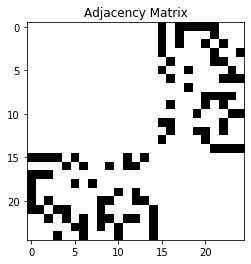

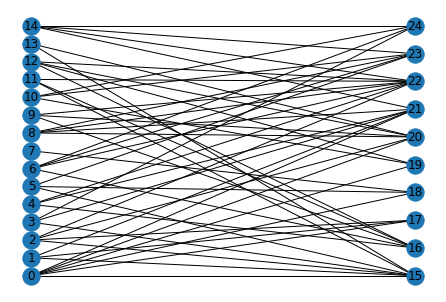

In [2]:
G = nx.bipartite.gnmk_random_graph(15, 10, 50, seed=123)

top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)

A = nx.adjacency_matrix(G)
A = A.toarray()
plt.title("Adjacency Matrix")
plt.imshow(A, cmap='Greys')
plt.show()

nx.draw(G, pos, with_labels=True)

Next, we split the graph into training and testing set by holding out 30% of the original edges (ref: maelfabien). Note that there are ongoing discussions about the importance of choosing test sets properly and the drastic impact it could have upon the performance result (see Yang et al).

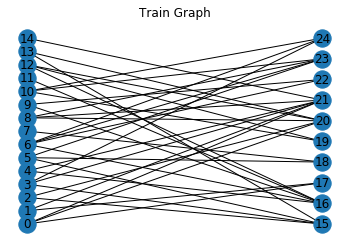

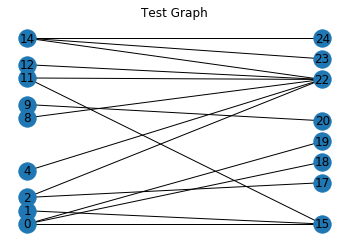

In [3]:
"""
TRAIN
ref: https://maelfabien.github.io/machinelearning/graph_4/#i-link-prediction
"""
# Remove 30% of the edges
proportion_edges = 0.3
# this is our test set
edge_subset = random.sample(G.edges(), int(proportion_edges * G.number_of_edges()))

# Create a copy of the graph and remove the edges
G_train = G.copy()
G_train.remove_edges_from(edge_subset)

# adjacency matrix
A_train = nx.adjacency_matrix(G_train)
A_train = A_train.toarray()

plt.title("Train Graph")
nx.draw(G_train, pos, with_labels=True)
plt.show()

"""
TEST
"""
G_test = nx.Graph()
G_test.add_edges_from(edge_subset)

plt.title("Test Graph")
nx.draw(G_test, pos, with_labels=True)
plt.show()

# 2. Evaluation Metric

There are two commonly used metrics to evaluate performance of link prediction algorithms: Mean Average Precision (MAP) and Receiver Operating Characteristics (ROC) & Precision-Recall Curves. There are certain caveats to each (see Yang et al) for further discussion, as this is beyond the scope of this article

Mean Average Precision / MAP is defined as a weighted rank (https://www.csie.ntu.edu.tw/~r01922164/SNA/Problems.pdf). 

$ MAP = \frac{\sum_{v \in V} AveP(v)}{|V|} $

$ AveP(v) = \frac{\sum_{i \in ranked N(i)} P(i)rel(i)}{|N(v)|}$

In [4]:
"""
Mean Average Precision
"""
def MAP(G_test, G_pred, thres = 0):

    # calculate avePrecision for each node and its neighbors
    avePs = []
    for node in tqdm(G_test.nodes()):

        # get predicted edges sorted in ranking order
        rankedPredWeights = sorted(G_pred[node].items(), key=lambda x: -x[1]['weight'])
        rankedPred = filter(lambda x: x[1]['weight'] > thres, rankedPredWeights)
        pred = [x[0] for x in rankedPred]

        # calculate rel
        # get groundtruth neighbors
        gt = set(G_test[node])
        rel = np.array([x in gt for x in pred])

        # calculate P
        predLength = len(pred)
        P = np.array([
            sum(rel[:i+1])/len(rel[:i+1]) for i in range(predLength)
        ])

        # calculate aveP
        aveP = (rel @ P)/len(gt)

        # keep track of results
        avePs.append(aveP)

    MAPvalue = sum(avePs) / len(avePs)
    
    print("MAP: {}".format(MAPvalue))

    return MAPvalue

Problem with fixed thresholds (as written in Yang et al), so we try every threshold and plot the resulting false positive and true positive rate. We can then calculate the area under the curve. Best is one.

In [43]:
"""
Visualise Receiver Operating Charateristics Curve and Precision-Recall Curve
"""
def ROC_PRC(pred, G):
    y_score = [p[2] for p in pred]
    y_true = [G.has_edge(p[0], p[1]) for p in pred]

    fig, (ax1, ax2) = plt.subplots(1, 2)

    fpr, tpr, thresholds = metrics.precision_recall_curve(y_true, y_score) 
    ax1.plot(fpr, tpr)
    ax1.set_title("Precision-Recall Curve")
    # ax1.set_xlabel("fpr")
    # ax1.set_ylabel("tpr")
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score) 
    ax2.plot(fpr, tpr)
    ax2.set_title("ROC Curve, AUC = {:.2f}".format(metrics.roc_auc_score(y_true, y_score)))
    # ax2.set_xlabel("fpr")
    # ax2.set_ylabel("tpr")
    
    plt.show()



# 3. Neighbours-based Techniques

Common link prediction techniques include assigning higher likelihood to edge connecting two vertices who share common neighbors. However in a bipartite graph, this is simply not true because no two connected vertices share the same immediate neighbors. This explains why algorithms that are based on common neighbors like Resource Allocation index, Jaccard Coefficient and Adamic-Adar don't work.

In [44]:
def allOnes(G_train):
    N = len(G_train.nodes())
    pred = [(i, j, 1) for i in range(N) for j in range(N)]

    return pred

<function allOnes at 0x7fc5a5442290>


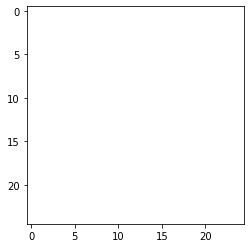

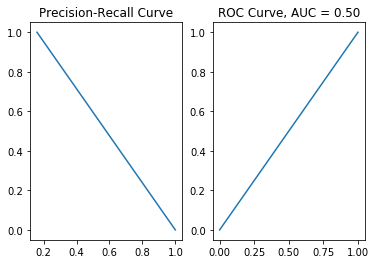

100%|██████████| 17/17 [00:00<00:00, 1068.76it/s]
MAP: 0.25032346732626043
<function resource_allocation_index at 0x7fc5bf835170>


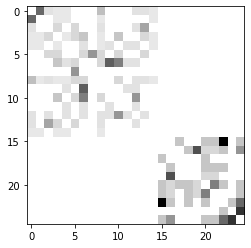

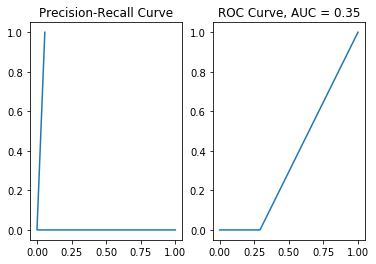

100%|██████████| 17/17 [00:00<00:00, 8108.16it/s]
MAP: 0.0
<function jaccard_coefficient at 0x7fc5bf8358c0>


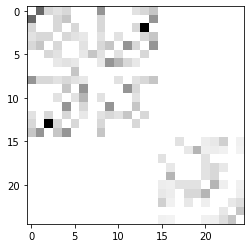

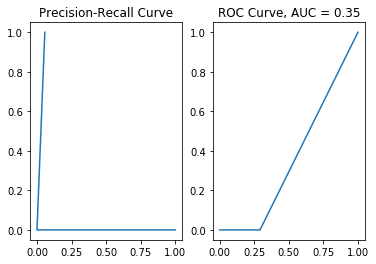

100%|██████████| 17/17 [00:00<00:00, 5270.78it/s]
MAP: 0.0
<function adamic_adar_index at 0x7fc5bf83b050>


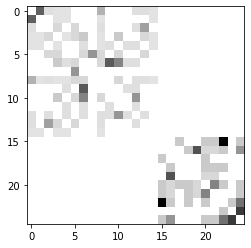

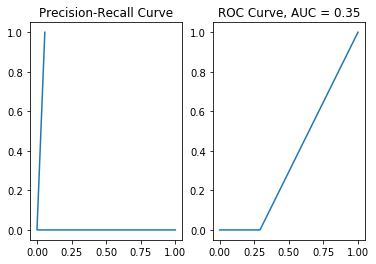

100%|██████████| 17/17 [00:00<00:00, 6994.62it/s]MAP: 0.0



In [45]:
for algo in [
    allOnes,
    nx.resource_allocation_index,
    nx.jaccard_coefficient,
    nx.adamic_adar_index
]:

    print(algo)

    pred = list(algo(G_train))

    # create graph
    G_pred = nx.Graph()
    G_pred.add_weighted_edges_from(pred)

    # visualise adjacency matrix
    Apred = nx.adjacency_matrix(G_pred)
    Apred = Apred.toarray()
    plt.imshow(Apred, cmap='Greys')
    plt.show()


    # evaluation
    ROC_PRC(pred, G)
    MAP(G_test, G_pred)


# 4. Spectral Curve Fitting

With the spectral evolution model, we assume that the eigenvectors of the adjacency matrix stay the same and only eigenvalues evolve. We treat link prediction problem as learning eigenvalues mapping. Note that only several F works this way. We'll look at several of them, also called kernel.

$ A = U \Lambda U^T $

$ A' = F(A) = U F(\Lambda) U^T $

Minimisation objective

$ min_F |F(A) - A'| = |U F(\Lambda) U^T - A'| = |F(\Lambda) - U^T A' U| $

This is equivalent to the following minimisation. F is equivalent to f. We can use curve fitting to derive the parameters for this function

$ min \sum_k (f(\Lambda_{kk}) - U^T_{k.} A' U_{.k})^2 $

We'll plot each pair of ($\Lambda_{kk}$, $U^T_{k.} A' U_{.k}$) to see what $f$ fits. We can experiment with several $F$ that is applicable to both adjacency matrix and the spectrum.  

- explain what is spectral transformation and eigenvalue decomposition
- explain kernel and why odd paths
- explain curve fitting problem and prediction task


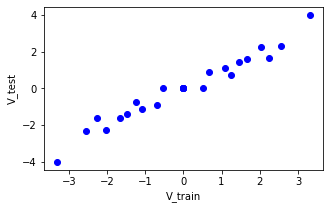

In [46]:
"""
Kernel as Curve Fitting Problem
"""

# eigenvalue decomposition
V_train, U_train = np.linalg.eig(A_train)

# U.T * Atest * U
target_V = U_train.T @ A @ U_train
# take only the diagonals
target_V = np.diag(target_V)

# need to do curve fitting
plt.figure(figsize=(5, 3))
plt.xlabel("V_train")
plt.ylabel("V_test")
plt.scatter(V_train, target_V, c='b')
plt.show()

explain odd path counting kernel. Only odd power works because we're looking at bipartite graph.

In [47]:
# odd path counting kernel function
class OddPathCountingKernel:
    def __init__(self):
        self.a1 = 0
        self.a3 = 0
        self.a5 = 0
        self.a7 = 0
        
    def func(self, V, a1, a3, a5, a7):   
        return V * a1 + V**3 * a3 + V**5 * a5 + V**7 * a7

    def fit(self, V_train, target_V):
        # do curve fitting
        popt, pcov = curve_fit(self.func, V_train, target_V)
        self.a1, self.a3, self.a5, self.a7 = popt

    def pred(self, V_train):
        return self.func(V_train, self.a1, self.a3, self.a5, self.a7)

explain sinh pseudokernel

In [48]:
# sinh pseudokernel function
class SinhPseudokernel:
    def __init__(self):
        self.alpha = 0
        
    def func(self, V, alpha):   
        return np.array([
            alpha * (np.exp(lamb) - np.exp(-lamb)) for lamb in V
        ])

    def fit(self, V_train, target_V):
        # do curve fitting
        popt, pcov = curve_fit(self.func, V_train, target_V)
        self.alpha, = popt

    def pred(self, V_train):
        return self.func(V_train, self.alpha)

explain odd neumann pseudokernel

In [49]:
# odd neumann pseudokernel function
class OddNeumannPseudokernel:
    def __init__(self):
        self.alpha = 0
        
    def func(self, V, alpha):   
        return np.array([
            alpha * (1/(1-lamb) - 1/(1+lamb)) for lamb in V
        ])

    def fit(self, V_train, target_V):
        # do curve fitting
        popt, pcov = curve_fit(self.func, V_train, target_V)
        self.alpha, = popt

    def pred(self, V_train):
        return self.func(V_train, self.alpha)

curve fitting

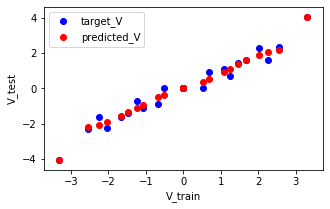

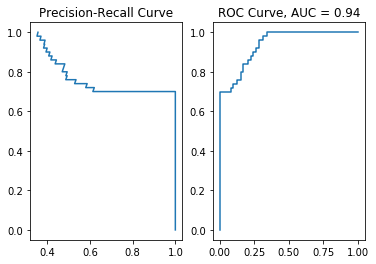

100%|██████████| 17/17 [00:00<00:00, 1842.13it/s]
MAP: 0.19028705499293733


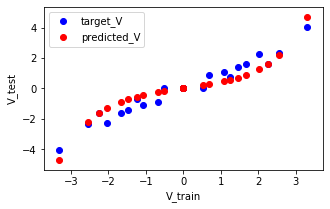

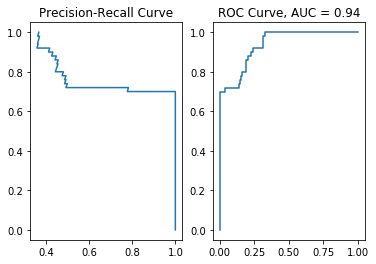

100%|██████████| 17/17 [00:00<00:00, 3486.37it/s]
MAP: 0.1857219577807813


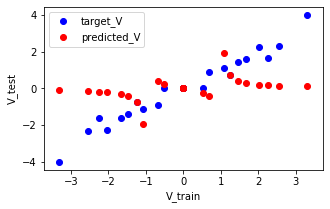

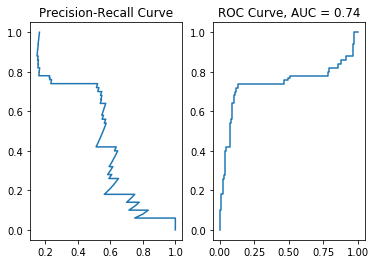

100%|██████████| 17/17 [00:00<00:00, 1991.99it/s]MAP: 0.15688608776844074



In [50]:
# fit kernel function
for kernel in [OddPathCountingKernel(), SinhPseudokernel(), OddNeumannPseudokernel()]:

    print(kernel)

    # kernel = OddPathCountingKernel()
    kernel.fit(V_train, target_V)
    V_pred = kernel.pred(V_train)

    # assume our function is exponential V_train with alpha = 0.6
    plt.figure(figsize=(5, 3))
    plt.xlabel("V_train")
    plt.ylabel("V_test")
    plt.scatter(V_train, target_V, c='b', label="target_V")
    plt.scatter(V_train, V_pred, c='r', label="predicted_V")
    plt.legend()
    plt.show()

    # transformation
    Apred = U_train @ np.diag(V_pred) @ U_train.T
    Apred = Apred.real

    # make edges of prediction
    pred = [(i, j, Apred[i, j]) for i in range(Apred.shape[0]) for j in range(Apred.shape[1])]

    # create graph
    G_pred = nx.Graph()
    G_pred.add_weighted_edges_from(pred)

    # evaluate MAP and precision
    ROC_PRC(pred, G)
    MAP(G_test, G_pred)
